In [1]:
import os
os.chdir("..")

In [2]:
import sys
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
from datetime import datetime
sys.path.insert(0, os.getcwd())

import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from tqdm import tqdm
import utilities.translator.tfq_translator as tfq_translator
import utilities.evaluator.evaluator as tfq_evaluator
import utilities.variational.tfq.variational as tfq_minimizer
import utilities.simplification.simplifier as penny_simplifier
import utilities.simplification.misc as simplification_misc#.kill_and_simplify
import utilities.simplification.tfq.gate_killer as tfq_killer
import utilities.database.database as database
import utilities.database.templates as templates
import utilities.mutator.idinserter as idinserter
import running.misc.misc as miscrun
import argparse
import ast
from importlib import reload


In [24]:
def load_ev_HEA(ns, itraj=1):

    args = {"problem":"TFIM", "params":"[1.,1.]","nrun":0, "shots":0, "epochs":500, "n_qubits":4, "vans_its":200,"itraj":itraj, "noisy":True,
            "noise_strength":ns, "acceptange_percentage": 0.01, "L_HEA":2,"run_name":"HEA"}
    args = miscrun.FakeArgs(args)
    L_HEA = args.L_HEA
    problem = args.problem
    params = ast.literal_eval(args.params)
    shots = miscrun.convert_shorts(args.shots)
    epochs = args.epochs
    n_qubits = args.n_qubits
    learning_rate=1e-4
    acceptange_percentage = args.acceptange_percentage
    noise_strength = args.noise_strength
    int_2_bool = lambda x: True if x==1 else False
    noisy = int_2_bool(args.noisy)
    tf.random.set_seed(abs(args.itraj))
    np.random.seed(abs(args.itraj))

    translator = tfq_translator.TFQTranslator(n_qubits = n_qubits, initialize="x", noisy=args.noisy, noise_strength = noise_strength)#, device_name="forest.numpy_wavefunction")
    translator_killer = tfq_translator.TFQTranslator(n_qubits = translator.n_qubits, initialize="x", noisy=translator.noisy, noise_strength = args.noise_strength)
    minimizer = tfq_minimizer.Minimizer(translator, mode="VQE", hamiltonian = problem, params = params, lr=learning_rate, shots=shots, patience=30, max_time_training=600, verbose=0)
    simplifier = penny_simplifier.PennyLane_Simplifier(translator)
    killer = tfq_killer.GateKiller(translator, translator_killer, hamiltonian=problem, params=params, lr=learning_rate, shots=shots, accept_wall = 2/args.acceptange_percentage)
    inserter = idinserter.IdInserter(translator, noise_in_rotations=1e-1, mutation_rate = 1.5)
    args_evaluator = {"n_qubits":translator.n_qubits, "problem":problem,"params":params,"nrun":args.itraj,"name":"HEA"}
    evaluator = tfq_evaluator.PennyLaneEvaluator(minimizer = minimizer, killer=killer, inserter = inserter, args=args_evaluator, lower_bound=translator.ground, stopping_criteria=1e-3, vans_its=args.vans_its, acceptange_percentage = acceptange_percentage)

    evaluator.load_dicts_and_displaying(evaluator.identifier)
    return evaluator

In [34]:
from tqdm import tqdm

In [38]:
evaluator.evolution.keys()

dict_keys([0, 1, 2, 3, 4])

In [44]:
ers = []
costs = {ns:{k:[] for k in range(5)} for ns in js}
for ns in js:
    for itraj in tqdm(range(1,18)):
        try:
            evaluator = load_ev_HEA(ns, itraj=itraj)
            for k in range(5):
                costs[ns][k].append(evaluator.evolution[k][1])
        except Exception:
            ers.append([ns, itraj])

100%|██████████| 17/17 [00:01<00:00, 16.42it/s]


In [48]:
costs_HEA = [[np.min(costs[ns][k]) for k in range(5)] for ns in js]

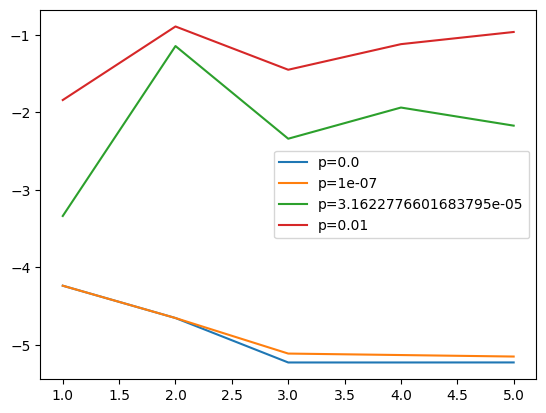

In [60]:
for k,ns in zip(costs_HEA,js):
    plt.plot(range(1,6),k, label="p={}".format(ns))
plt.legend()

In [61]:
def load_ev(ns, itraj=1):

    args = {"problem":"TFIM", "params":"[1.,1.]","nrun":0, "shots":0, "epochs":500, "n_qubits":4, "vans_its":200,"itraj":itraj, "noisy":True,
            "noise_strength":ns, "acceptange_percentage": 0.01, "L_HEA":2,"run_name":""}
    args = miscrun.FakeArgs(args)
    L_HEA = args.L_HEA
    problem = args.problem
    params = ast.literal_eval(args.params)
    shots = miscrun.convert_shorts(args.shots)
    epochs = args.epochs
    n_qubits = args.n_qubits
    learning_rate=1e-4
    acceptange_percentage = args.acceptange_percentage
    noise_strength = args.noise_strength
    int_2_bool = lambda x: True if x==1 else False
    noisy = int_2_bool(args.noisy)
    tf.random.set_seed(abs(args.itraj))
    np.random.seed(abs(args.itraj))

    translator = tfq_translator.TFQTranslator(n_qubits = n_qubits, initialize="x", noisy=args.noisy, noise_strength = noise_strength)#, device_name="forest.numpy_wavefunction")
    translator_killer = tfq_translator.TFQTranslator(n_qubits = translator.n_qubits, initialize="x", noisy=translator.noisy, noise_strength = args.noise_strength)
    minimizer = tfq_minimizer.Minimizer(translator, mode="VQE", hamiltonian = problem, params = params, lr=learning_rate, shots=shots, patience=30, max_time_training=600, verbose=0)
    simplifier = penny_simplifier.PennyLane_Simplifier(translator)
    killer = tfq_killer.GateKiller(translator, translator_killer, hamiltonian=problem, params=params, lr=learning_rate, shots=shots, accept_wall = 2/args.acceptange_percentage)
    inserter = idinserter.IdInserter(translator, noise_in_rotations=1e-1, mutation_rate = 1.5)
    args_evaluator = {"n_qubits":translator.n_qubits, "problem":problem,"params":params,"nrun":args.itraj,"name":""}
    evaluator = tfq_evaluator.PennyLaneEvaluator(minimizer = minimizer, killer=killer, inserter = inserter, args=args_evaluator, lower_bound=translator.ground, stopping_criteria=1e-3, vans_its=args.vans_its, acceptange_percentage = acceptange_percentage)

    evaluator.load_dicts_and_displaying(evaluator.identifier)
    return evaluator

In [80]:
ersV = []
costs_vans = {ns:[] for ns in js}
evaluators_vans = {ns:[] for ns in js}
for ns in js:
    for itraj in tqdm(range(1,18)):
        try:
            evaluator = load_ev(ns, itraj=itraj)
            costs_vans[ns].append(evaluator.evolution[evaluator.get_best_iteration()][1])
            evaluators_vans[ns].append(evaluator)
        except Exception:
            ersV.append([ns, itraj])

100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


In [193]:
def get_its(ev):

    it=0
    for k in ev.raw_history.values():
        if k[5] == "mutation":
            it+=1
    return it

In [ ]:
[[ev.get_b for ev in evaluators_vans[ns]] for ns in js]

In [197]:
[[get_its(ev) for ev in evaluators_vans[ns]] for ns in js]

[[20, 19, 29, 26, 27, 17, 23, 18, 21, 11, 19, 23, 32, 18, 31, 15, 17],
 [96, 53, 102, 104, 147, 86, 63, 44, 83, 35, 64, 55, 112, 127, 79],
 [200,
  155,
  200,
  189,
  200,
  133,
  137,
  200,
  200,
  93,
  198,
  105,
  200,
  200,
  200,
  57,
  159],
 [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]]

In [201]:
[ev.get_best_iteration() for ev in best_evs.values()]

[6, 9, 2, 6]

In [209]:
evi = best_evs[js[-1]]
bb = evi.get_best_iteration()
db = evi.evolution[bb][0]
evi.minimizer.translator.give_circuit(db, unresolved=False)[0]

(0, 0): ───D(0.01)───Rx(0.042π)───D(0.01)───@───D(0.01)───Rz(0.131π)───D(0.01)───Rx(0)───D(0.01)───Rz(0.169π)───
                                            │
(0, 1): ───D(0.01)──────────────────────────X───D(0.01)───Rz(0.168π)────────────────────────────────────────────

(0, 2): ───D(0.01)───Rz(0.187π)─────────────────────────────────────────────────────────────────────────────────

(0, 3): ───D(0.01)───Rz(0.118π)─────────────────────────────────────────────────────────────────────────────────

In [202]:
[[ev.get_best_iteration() for ev in evaluators_vans[ns]] for ns in js]

[[11, 13, 13, 18, 18, 13, 7, 8, 15, 9, 10, 13, 18, 13, 17, 6, 12],
 [7, 6, 8, 4, 11, 6, 5, 8, 6, 11, 8, 9, 8, 9, 11],
 [6, 2, 4, 3, 4, 3, 3, 3, 4, 1, 1, 4, 14, 3, 0, 5, 3],
 [5, 6, 2, 2, 4, 1, 3, 3, 9, 4, 4, 3, 0]]

In [166]:
mean_costs_vans = np.array([np.mean(costs_vans[ns]) for ns in js])
std_costs_vans = np.array([np.std(costs_vans[ns]) for ns in js])

In [82]:
best_costs_vans = [np.min(costs_vans[ns]) for ns in js]

In [186]:
best_costs_HEA = np.array([np.min(costs[ns][best_layers_HEA[ind]]) for ind,ns in enumerate(js)])


In [187]:
mean_costs_HEA =  np.array([np.mean(costs[ns][best_layers_HEA[ind]]) for ind,ns in enumerate(js)])
std_costs_HEA =  np.array([np.std(costs[ns][best_layers_HEA[ind]]) for ind,ns in enumerate(js)])

Text(0, 0.5, 'Energy attained')

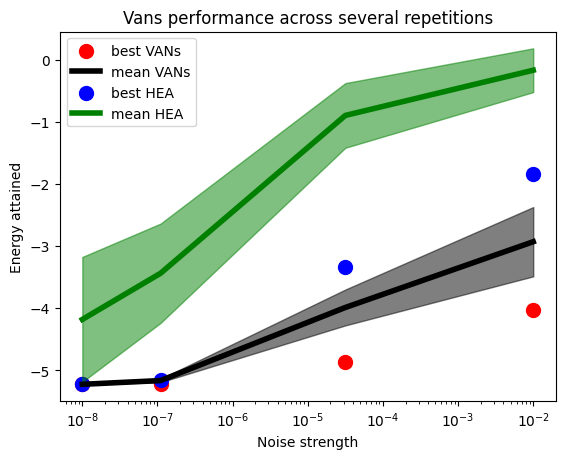

In [190]:
ax=plt.subplot()
ax.set_title("Vans performance across several repetitions")
ax.scatter(js+1e-8,best_costs_vans,s=100, color="red", label="best VANs")
ax.plot(js+1e-8,mean_costs_vans, linewidth=4,label="mean VANs",color="black")
ax.fill_between(js+1e-8,mean_costs_vans- std_costs_vans*.5, mean_costs_vans+std_costs_vans*.5, alpha=0.5, color="black")

ax.scatter(js+1e-8,best_costs_HEA,s=100, color="blue", label="best HEA")
ax.plot(js+1e-8,mean_costs_HEA,linewidth=4, label="mean HEA",color="green")
ax.fill_between(js+1e-8,mean_costs_HEA- std_costs_HEA*.5, mean_costs_HEA+std_costs_HEA*.5, alpha=0.5, color="green")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Noise strength")
ax.set_ylabel("Energy attained")

[6, 9, 2, 6]

In [86]:
wheres = [np.argmin(costs_vans[ns]) for k,ns in enumerate(js)]

In [98]:
best_evs = {ns: evaluators_vans[ns][wheres[k]] for k,ns in enumerate(js)}
#[best_evs[ns].minimizer.translator.noise_strength for ns in js] CHECK -it's ok- :)

In [103]:
best_structures_vans = [database.describe_circuit(best_evs[ns].minimizer.translator, best_evs[ns].evolution[best_evs[ns].get_best_iteration()][0]) for ns in js]

In [107]:
structures_HEA = [database.describe_circuit(evaluator.minimizer.translator, database.concatenate_dbs([templates.hea_layer(evaluator.minimizer.translator)]*L)) for L in range(1,6)]

In [108]:
structures_HEA

[(8, 4), (16, 8), (24, 12), (32, 16), (40, 20)]

In [109]:
best_structures_vans

[(82, 42), (33, 7), (8, 0), (7, 1)]

In [143]:
costs_HEA

[[-4.2360682, -4.6530137, -5.2262187, -5.2261543, -5.2257],
 [-4.236068, -4.653042, -5.111307, -5.1303635, -5.1496525],
 [-3.3369713, -1.1453906, -2.3404398, -1.9385116, -2.1720276],
 [-1.8416083, -0.89300036, -1.4509408, -1.120964, -0.96393454]]

In [144]:
best_layers_HEA = [np.argmin(costs_HEA[k]) for k,ns in enumerate(js)]

Text(0, 0.5, '# Cnots')

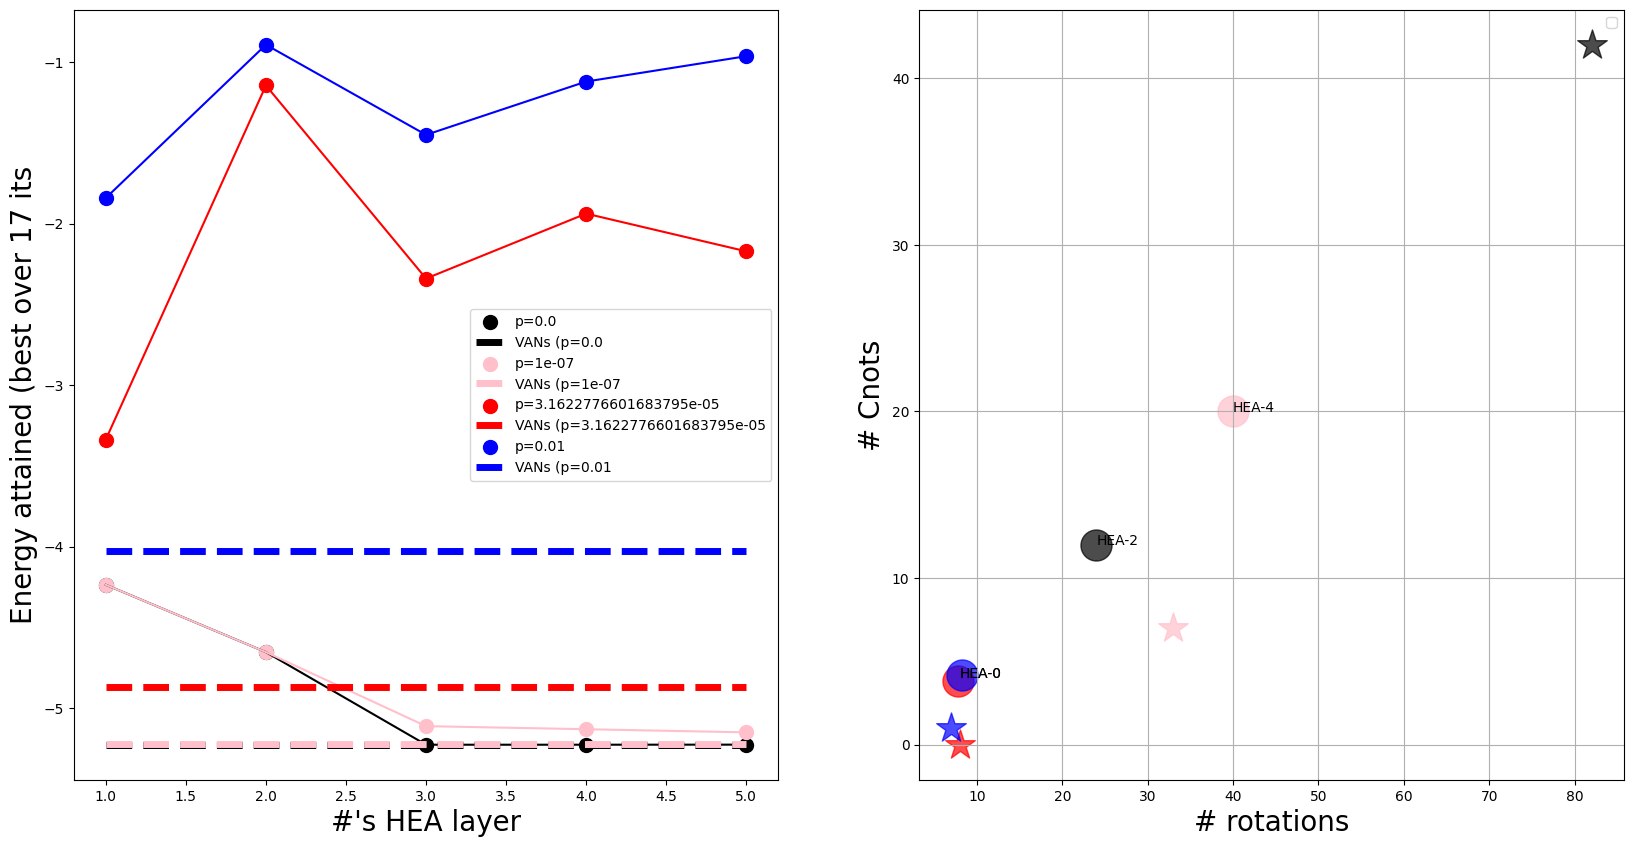

In [160]:
colors = ["black", "pink", "red", "blue"]
plt.figure(figsize=(20,10))
ax=plt.subplot(121)
for ind,k in enumerate(costs_HEA):
    ax.plot(range(1,6),k,'-', c=colors[ind])
    ax.scatter(range(1,6),k,s=100, c=colors[ind], label="p={}".format(js[ind]))
    ax.plot(range(1,6), np.ones(len(range(1,6)))*best_costs_vans[ind],'--',linewidth=5,c=colors[ind], label="VANs (p={})".format(js[ind]))
ax.legend()
ax.set_xlabel("#'s HEA layer",size=20)
ax.set_ylabel("Energy attained (best over {} its".format(17),size=20)

ax=plt.subplot(122)
for ind,k in enumerate(costs_HEA):
    ax.scatter(*(structures_HEA[best_layers_HEA[ind]]+ [0.,0,-.2,.2][ind]*np.array([1,1])), s=500,marker="o", alpha=0.7, c=colors[ind])
    ax.scatter(*best_structures_vans[ind], marker="*", s=500, alpha=0.7,c=colors[ind])
    ax.annotate('HEA-{}'.format(best_layers_HEA[ind]), structures_HEA[best_layers_HEA[ind]])
    #ax.scatter(range(1,6),k,s=100, c=colors[ind], label="p={}".format(js[ind]))
    #ax.axhline(best_costs_vans[ind],c=colors[ind])
ax.legend()
ax.grid()
ax.set_xlabel("# rotations",size=20)
ax.set_ylabel("# Cnots", size=20)
